###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2021 Lorena A. Barba

# Linear regression by gradient descent

This module of _Engineering Computations_ takes a step-by-step approach to introduce you to the essential ideas of deep learning, an algorithmic technology that is taking the world by storm. 
It is at the core of the artificial intelligence boom, and we think every scientist and engineer should understand the basics, at least. 

Another term for deep learning is deep neural networks. 
In this module, you will learn how neural-network models are built, computationally. 
The inspiration for deep learning may have been how the brain works, but in practice what we have is a method to build models, using mostly linear algebra and a little bit of calculus. 
These models are not magical, or even "intelligent"—they are just about _optimization_, which every engineer knows about!

We start with the very basics of model-building: linear regression. 
In Module 1 of the _Engineering Computations_ series, we discuss [linear regression with real data](http://go.gwu.edu/engcomp1lesson5), and find the model parameters (slope and $y$-intercept) analytically. 
Let's forget about that for this lesson. 
The key concept here will be _gradient descent_. Start your ride here!

## Gradient descent

This lesson is partly based on a tutorial at the 2019 SciPy Conference by Eric Ma [1]. He begins his tutorial by presenting the idea of _gradient descent_ with a simple quadratic function: the question is how do we find this function's minimum?

$$f(w) = w^2 +3w -5$$

We know from calculus that at the minimum, the derivative of the function is zero (the tangent to the function curve is horizontal), and the second derivative is positive (the curve slants _up_ on each side of the minimum). 
The analytical derivative of the function above is $f^\prime(w) = 2w + 3$ and the second derivative is $f^{\prime\prime}(w)=2>0$. Thus, we make $2w+3=0$ to find the minimum.

Let's play with this function using SymPy. We'll later use NumPy, and make plots with Matplotlib, so we load all the libraries in one place.

In [1]:
import sympy
import numpy

from matplotlib import pyplot
%matplotlib inline

We run this SymPy method to get beautiful typeset symbols and equations (in the Jupyter notebook, it will use [MathJax](https://en.wikipedia.org/wiki/MathJax) by default): 

In [2]:
sympy.init_printing()

Now we'll define the Python variable `w` to be a SymPy symbol, and create the expression `f` to match the mathematical function above, and plot it.

In [3]:
w = sympy.Symbol('w', real=True)

f = w**2 + 3*w - 5
f

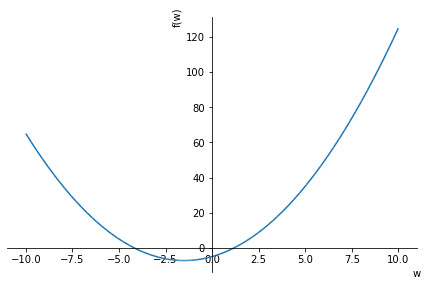

In [4]:
sympy.plotting.plot(f);

A neat parabola. We can see from the plot that the minimum of $f(w)$ is reached somewhere between $w=-2.5$ and $w=0$. SymPy can tell us the derivative, and the value where it is zero:

In [5]:
fprime = f.diff(w)
fprime

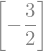

In [6]:
sympy.solve(fprime, w)

That looks about right: $-3/2$ or $-1.5$. 
We could have also solved this by hand, because it's a simple function. 
But for more complicated functions, finding the minimum analytically can get messy. 
Instead, we can use the iterative method of gradient descent. 

The idea in gradient descent is to find the value of $w$ at the function minimum by starting with an initial guess, then iteratively taking small steps down the slope of the function, i.e., in the negative gradient direction. 
To illustrate the process, we turn the symbolic expression `fprime` into a Python function that we can call, and use it in a simple loop taking small steps:

In [7]:
fpnum = sympy.lambdify(w, fprime)
type(fpnum)

function

Yep. We got a Python function with the [`sympy.lambdify()`](https://docs.sympy.org/latest/modules/utilities/lambdify.html) method, whose return value is of type `function`. Now, you can pick any starting guess, say $w=10$, and advance in a loop taking steps of size $0.01$:

In [8]:
w = 10.0   # starting guess for the min

for i in range(1000):
    w = w - fpnum(w)*0.01 # with 0.01 the step size

print(w)

-1.4999999806458753


That gave a result very close to the true value $-1.5$, and all we needed was a function for the derivative of $f(w)$. This is how you find the argument of the minimum of a function iteratively. 

##### Note

> Implied in this method is that the function is differentiable, and that we can step *down* the slope, meaning its second derivative is positive, or the function is _convex_.

<img src="../images/descent.png" style="width: 400px;"/> 

#### Gradient descent steps in the direction of the negative slope to approach the minimum.

## Linear regression

Suppose you have data consisting of one independent variable and one dependent variable, and when you plot the data it seems to noisily follow a line. 
To build a model with this data, you assume the relationship is _linear_, and seek to find the line's slope and $y$-intercept (the model parameters) that best fit the data. 

Let's make some synthetic data to play with, following the example in Eric Ma's tutorial [1].

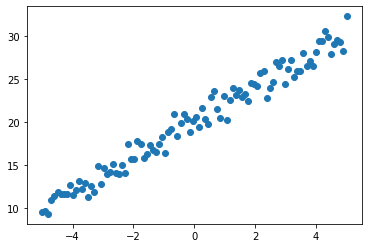

In [9]:
# make sythetic data (from Eric's example)
x_data = numpy.linspace(-5, 5, 100)
w_true = 2
b_true = 20

y_data = w_true*x_data + b_true + numpy.random.normal(size=len(x_data))

pyplot.scatter(x_data,y_data);

This situation arises often. In **Module 1** of _Engineering Computations_, we used a real data set of Earth temperature over time and fit an ominously sloped line. 
We derived analytical formulas for the model coefficients and wrote our own custom functions, and we also learned that NumPy has a function that will do it for us: `numpy.polyfit(x, y, 1)` will return the two parameters $w, b$ for the line

$$y = w x + b $$

Here, we will use gradient descent to get the parameters of the linear model. 
The first step is to define a function that represents the _deviation_ of the data from the model. 
For linear regression, we use the sum (or the mean) of the square errors, also called _residuals_, or the difference between each data point and the predicted value from the linear model.

<img src="../images/residuals.png" style="width: 400px;"/> 

#### Each data point deviates from the linear regression: we aim to minimize the sum of squares of the residuals.


Let's review our ingredients:

1. observational data, in the form of two arrays: $x, y$
2. our linear model: $y = wx + b$
3. a function that measures the discrepancy between the data and the fitting line: $\frac{1}{N}\sum (y_i - f(x_i))^2$

The last item is called a "loss function" (also sometimes "cost function"). Our method will be to step down the slope of the loss function, to find its minimum.

As a first approach, let's again use SymPy, which can compute derivatives for us. Below, we define the loss function for a single data point, and make Python functions with its derivatives with respect to the model parameters. 
We call these functions in a sequence of steps that start at an initial guess for the parameters (we choose zero), and step in the negative gradient multiplied by a step size (we choose $0.01$). 
After $1000$ steps, you see that the values of $w$ and $b$ are quite close to the true values from our synthetic data.

In [10]:
w, b, x, y = sympy.symbols('w b x y')

loss = (w*x + b - y)**2
loss

In [11]:
grad_b = sympy.lambdify([w,b,x,y], loss.diff(b), 'numpy')
grad_w = sympy.lambdify([w,b,x,y], loss.diff(w), 'numpy')

Be sure to read the documentation for [`sympy.lambdify()`](https://docs.sympy.org/latest/modules/utilities/lambdify.html), which explains the argument list.

In [12]:
w = 0
b = 0

for i in range(1000):
    descent_b = numpy.sum(grad_b(w,b,x_data,y_data))/len(x_data)
    descent_w = numpy.sum(grad_w(w,b,x_data,y_data))/len(x_data)
    w = w - descent_w*0.01 # with 0.01 the step size
    b = b - descent_b*0.01 

print(w)
print(b)

2.03136593978268
20.030956250406764


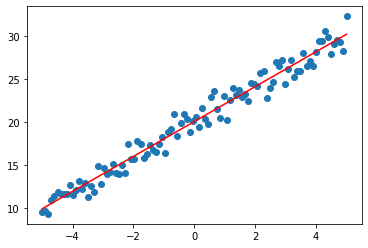

In [13]:
pyplot.scatter(x_data,y_data)
pyplot.plot(x_data, w*x_data + b, '-r');

It works! That line looks to be fitting the data pretty well. Now we have a "best fit" line that represents the data, and that we can use to estimate the value of the dependent variable for any value of the independent variable, even if not present in the data. That is, _to make predictions_.

##### Note

> "Learning" means minimizing a loss function (a.k.a cost function), which involves computing derivatives with respect to the parameteres in the model. 

Here, we used SymPy to help us out with the derivatives, but for more complex models (which may have many parameters), this would be a cumbersome approach. 
Instead, we make use of the technique of _automatic differentiation_, which evaluates the derivative of a function written in code. 
You'll learn more about it in the next lesson, on **logistic regression**.

## References

1. Eric Ma, "Deep Learning Fundamentals: Forward Model, Differentiable Loss Function & Optimization," SciPy 2019 tutorial. [video on YouTube](https://youtu.be/JPBz7-UCqRo) and [archive on GitHub](https://github.com/ericmjl/dl-workshop/releases/tag/scipy2019).

In [14]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())